In [55]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import re
import argparse
import random
import string
import keras
from transformers import pipeline
from tensorflow.keras import layers
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose, TextVectorization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K

Генеруємо MNIST-зображення за допомогою VAE

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
img_size = x_train.shape[1]
train_len = 10000
test_len = 1000
x_train = np.reshape(x_train[:train_len], [-1, img_size, img_size, 1])
x_test = np.reshape(x_test[:test_len], [-1, img_size, img_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_test = y_test[:test_len]

In [4]:
print(x_test.shape)

(1000, 28, 28, 1)


In [5]:
print(x_train.shape)

(10000, 28, 28, 1)


y_train[5] =  2
y_train[50] =  3
y_train[500] =  3
y_train[5000] =  7


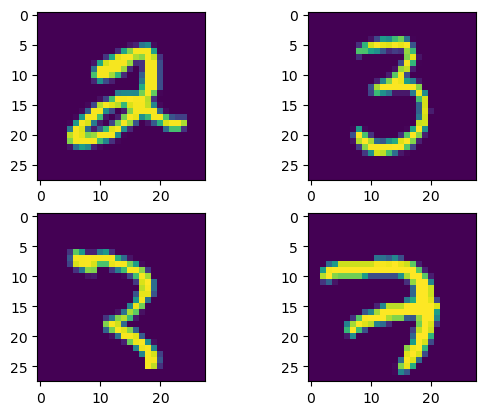

In [6]:
show_x_train = x_train.reshape(-1,28,28)
plt.figure(1)
plt.subplot(221)
plt.imshow(show_x_train[5])
print('y_train[5] = ', y_train[5])

plt.subplot(222)
plt.imshow(show_x_train[50])
print('y_train[50] = ', y_train[50])

plt.subplot(223)
plt.imshow(show_x_train[500])
print('y_train[500] = ', y_train[500])

plt.subplot(224)
plt.imshow(show_x_train[5000])
print('y_train[5000] = ', y_train[5000])
plt.show()

In [7]:
input_shape = (img_size, img_size, 1)
batch_size = 32
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 50
use_mse = True
load_weights = False

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [9]:
#задаємо параметри для майбутнього графу
def plot_results(encoder, decoder, x_test, y_test, batch_size=128):
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range 
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("Z[0]")
    plt.ylabel("Z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

In [10]:
#будуємо енкодер
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

shape = K.int_shape(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [11]:
#будуємо декодер
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')

In [12]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [13]:
if use_mse:
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
else:
    reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                              K.flatten(outputs))

reconstruction_loss *= img_size * img_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [14]:
vae.compile(optimizer='rmsprop')

if load_weights:
    vae = vae.load_weights(args.weights)
else:
    vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/50
313/313 [==============================] - 7s 21ms/step - loss: 54.1418 - val_loss: 48.3685
Epoch 2/50
313/313 [==============================] - 6s 21ms/step - loss: 47.5667 - val_loss: 45.3683
Epoch 3/50
313/313 [==============================] - 7s 21ms/step - loss: 44.8370 - val_loss: 42.9979
Epoch 4/50
313/313 [==============================] - 7s 21ms/step - loss: 43.5371 - val_loss: 42.1840
Epoch 5/50
313/313 [==============================] - 7s 21ms/step - loss: 42.6633 - val_loss: 43.2666
Epoch 6/50
313/313 [==============================] - 7s 21ms/step - loss: 42.0163 - val_loss: 41.9498
Epoch 7/50
313/313 [==============================] - 7s 21ms/step - loss: 41.4840 - val_loss: 42.6089
Epoch 8/50
313/313 [==============================] - 7s 21ms/step - loss: 40.9730 - val_loss: 41.3598
Epoch 9/50
313/313 [==============================] - 7s 21ms/step - loss: 40.6272 - val_loss: 40.8847
Epoch 10/50
313/313 [==============================] - 7s 21ms/step - los

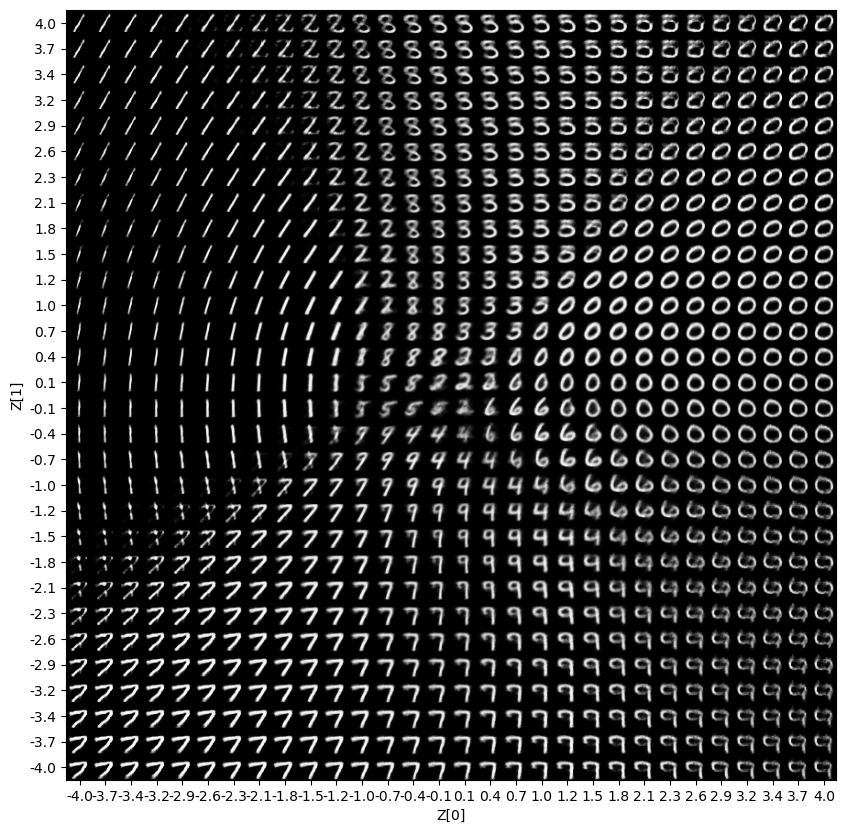

In [42]:
plot_results(encoder, decoder, x_test, y_test, batch_size=batch_size)

In [23]:
with open("C:/Users/LEGION/anaconda3/dutch.txt", encoding='utf-8') as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng = line.split("\t")[0]
    dutch = line.split("\t")[1]
    dutch = "[start] " + dutch + " [end]"
    text_pairs.append((eng, dutch))

In [24]:
len(text_pairs)

70549

In [27]:
for _ in range(5):
    print(random.choice(text_pairs))

('My dad bought me books.', '[start] Papa heeft boeken voor me gekocht. [end]')
('Tom tore the letter up.', '[start] Tom verscheurde de brief. [end]')
('Tom had one arm in a sling.', '[start] Tom had één arm in een mitella. [end]')
("Tom is being sensible, isn't he?", '[start] Tom is verstandig, of niet? [end]')
('This house has six rooms.', '[start] Dit huis heeft zes kamers. [end]')


In [28]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

70549 total pairs
49385 training pairs
10582 validation pairs
10582 test pairs


In [40]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
dutch_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_dutch_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
dutch_vectorization.adapt(train_dutch_texts)

In [42]:
def format_dataset(eng, dutch):
    eng = eng_vectorization(eng)
    dutch = dutch_vectorization(dutch)
    return ({"encoder_inputs": eng, "decoder_inputs": dutch[:, :-1],}, dutch[:, 1:])


def make_dataset(pairs):
    eng_texts, dutch_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    dutch_texts = list(dutch_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, dutch_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)


In [43]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


In [46]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


In [49]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [51]:
epochs = 5

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [54]:
dutch_vocab = dutch_vectorization.get_vocabulary()
dutch_index_lookup = dict(zip(range(len(dutch_vocab)), dutch_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = dutch_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = dutch_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence)
    print(translated)
    print('------------------------')

Tom invested all his money in the company that Mary and her father managed.
[start] tom heeft al zijn geld in zijn vader gezegd dat hij haar vader en haar vader [end]
------------------------
Where are the meters?
[start] waar zijn de zit [end]
------------------------
Tom insulted Mary.
[start] tom heeft mary samen gemaakt [end]
------------------------
Yes. That's right.
[start] dom dat [end]
------------------------
Tom thinks Mary is angry.
[start] tom denkt dat mary boos is [end]
------------------------
Tom and Mary are singing.
[start] tom en mary zingen [end]
------------------------
Stop complaining.
[start] stoppen met het met eten [end]
------------------------
Mom, where's my handkerchief?
[start] waar is mijn moeder aan de schuld [end]
------------------------
I think we'll need more food.
[start] ik denk dat meer meer eten [end]
------------------------
I had nothing to do with her.
[start] ik had niets met haar te doen [end]
------------------------
Ask Tom if he voted.


In [56]:
pipe_classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

C:\Users\LEGION\anaconda3\lib\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LEGION\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [57]:
txt_1 = 'My computer thinks I am gay, I throw that piece of junk away'
pipe_classifier(txt_1)

[{'label': 'NEGATIVE', 'score': 0.9997525811195374}]

In [58]:
txt_2 = 'To be, or not to be, that is the question. Whether this nobler in the mind to suffer'
pipe_classifier(txt_2)

[{'label': 'NEGATIVE', 'score': 0.777101457118988}]

In [59]:
txt_3 = 'Does death come alone, or with eager reinforcements?'
pipe_classifier(txt_3)

[{'label': 'NEGATIVE', 'score': 0.9983548521995544}]

In [60]:
txt_4 = 'Tonight I am gonna have myself a real good time, I feel alive. And the world: Ill turn it inside out, yeah, I am floating around in ecstasy'
pipe_classifier(txt_4)

[{'label': 'POSITIVE', 'score': 0.9994803071022034}]

In [61]:
txt_5 = 'Like so many lemurs, it is completely nocturnal in its habits, living either alone or in pairs, chiefly in the bamboo forests.'
pipe_classifier(txt_5)

[{'label': 'NEGATIVE', 'score': 0.699472188949585}]